In [1]:
import importlib
import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import prettypyplot as pplt
import scipy
import seaborn as sns
from matplotlib import ticker
from sklearn import metrics

import extq

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import plotting
import util

In [3]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

In [4]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

# Load data

In [5]:
DATA_DIR = "/project/dinner/scguo/ci-vsd/data"

ivac_trajs = np.load(
    f"{DATA_DIR}/raw_feat/ivac_less_feat_10-1000.npy", allow_pickle=True
)
ivac_models = np.load(f"{DATA_DIR}/models_ivac_less_feat_10-1000.npy")
# S4 translocation/rotation data
cv_trajs = list(
    np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(np.load(f"{DATA_DIR}/raw_feat/cv_dist_spin_anton2.npy")[:115])
cv_arr = np.concatenate(cv_trajs)
# salt bridge distances for states
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
sb_trajs.extend(np.load("../../data/raw_feat/feat2_raw_anton2.npy")[:115])
sb_arr = np.concatenate(sb_trajs)
# committors
lag = 500
qp_du = np.load(f"{DATA_DIR}/feat2_dist_du_anton2/qp_downup_3.npy", allow_pickle=True)[
    8
]  # 50 ns lag time
# weights
weights = np.load(
    f"{DATA_DIR}/feat2_dist_du_anton2/weights_3_feat5ivac.npy", allow_pickle=True
)[
    8
]  # 0.1 ns lag time

In [6]:
dist = [t[:, 0] for t in cv_trajs]
rot = [t[:, 1] for t in cv_trajs]
tic1 = [t[:, 1] for t in ivac_trajs]
tic2 = [t[:, 2] for t in ivac_trajs]

In [7]:
from scipy import stats

In [8]:
models = np.loadtxt("/project/dinner/scguo/ci-vsd/models/MD-clustering-center/all.txt")

/project/dinner/scguo/extq/src/extq/projection.py:140: RuntimeWarning: invalid value encountered in true_divide
  return numer / denom
/scratch/local/jobs/278587/ipykernel_578728/3835947255.py:12: RuntimeWarning: invalid value encountered in sqrt
  q_std = np.sqrt(q_avg_sq - q_avg ** 2)
/scratch/local/jobs/278587/ipykernel_578728/3835947255.py:29: RuntimeWarning: invalid value encountered in sqrt
  q_std_tic = np.sqrt(q_avg_sq_tic - q_avg_tic ** 2)


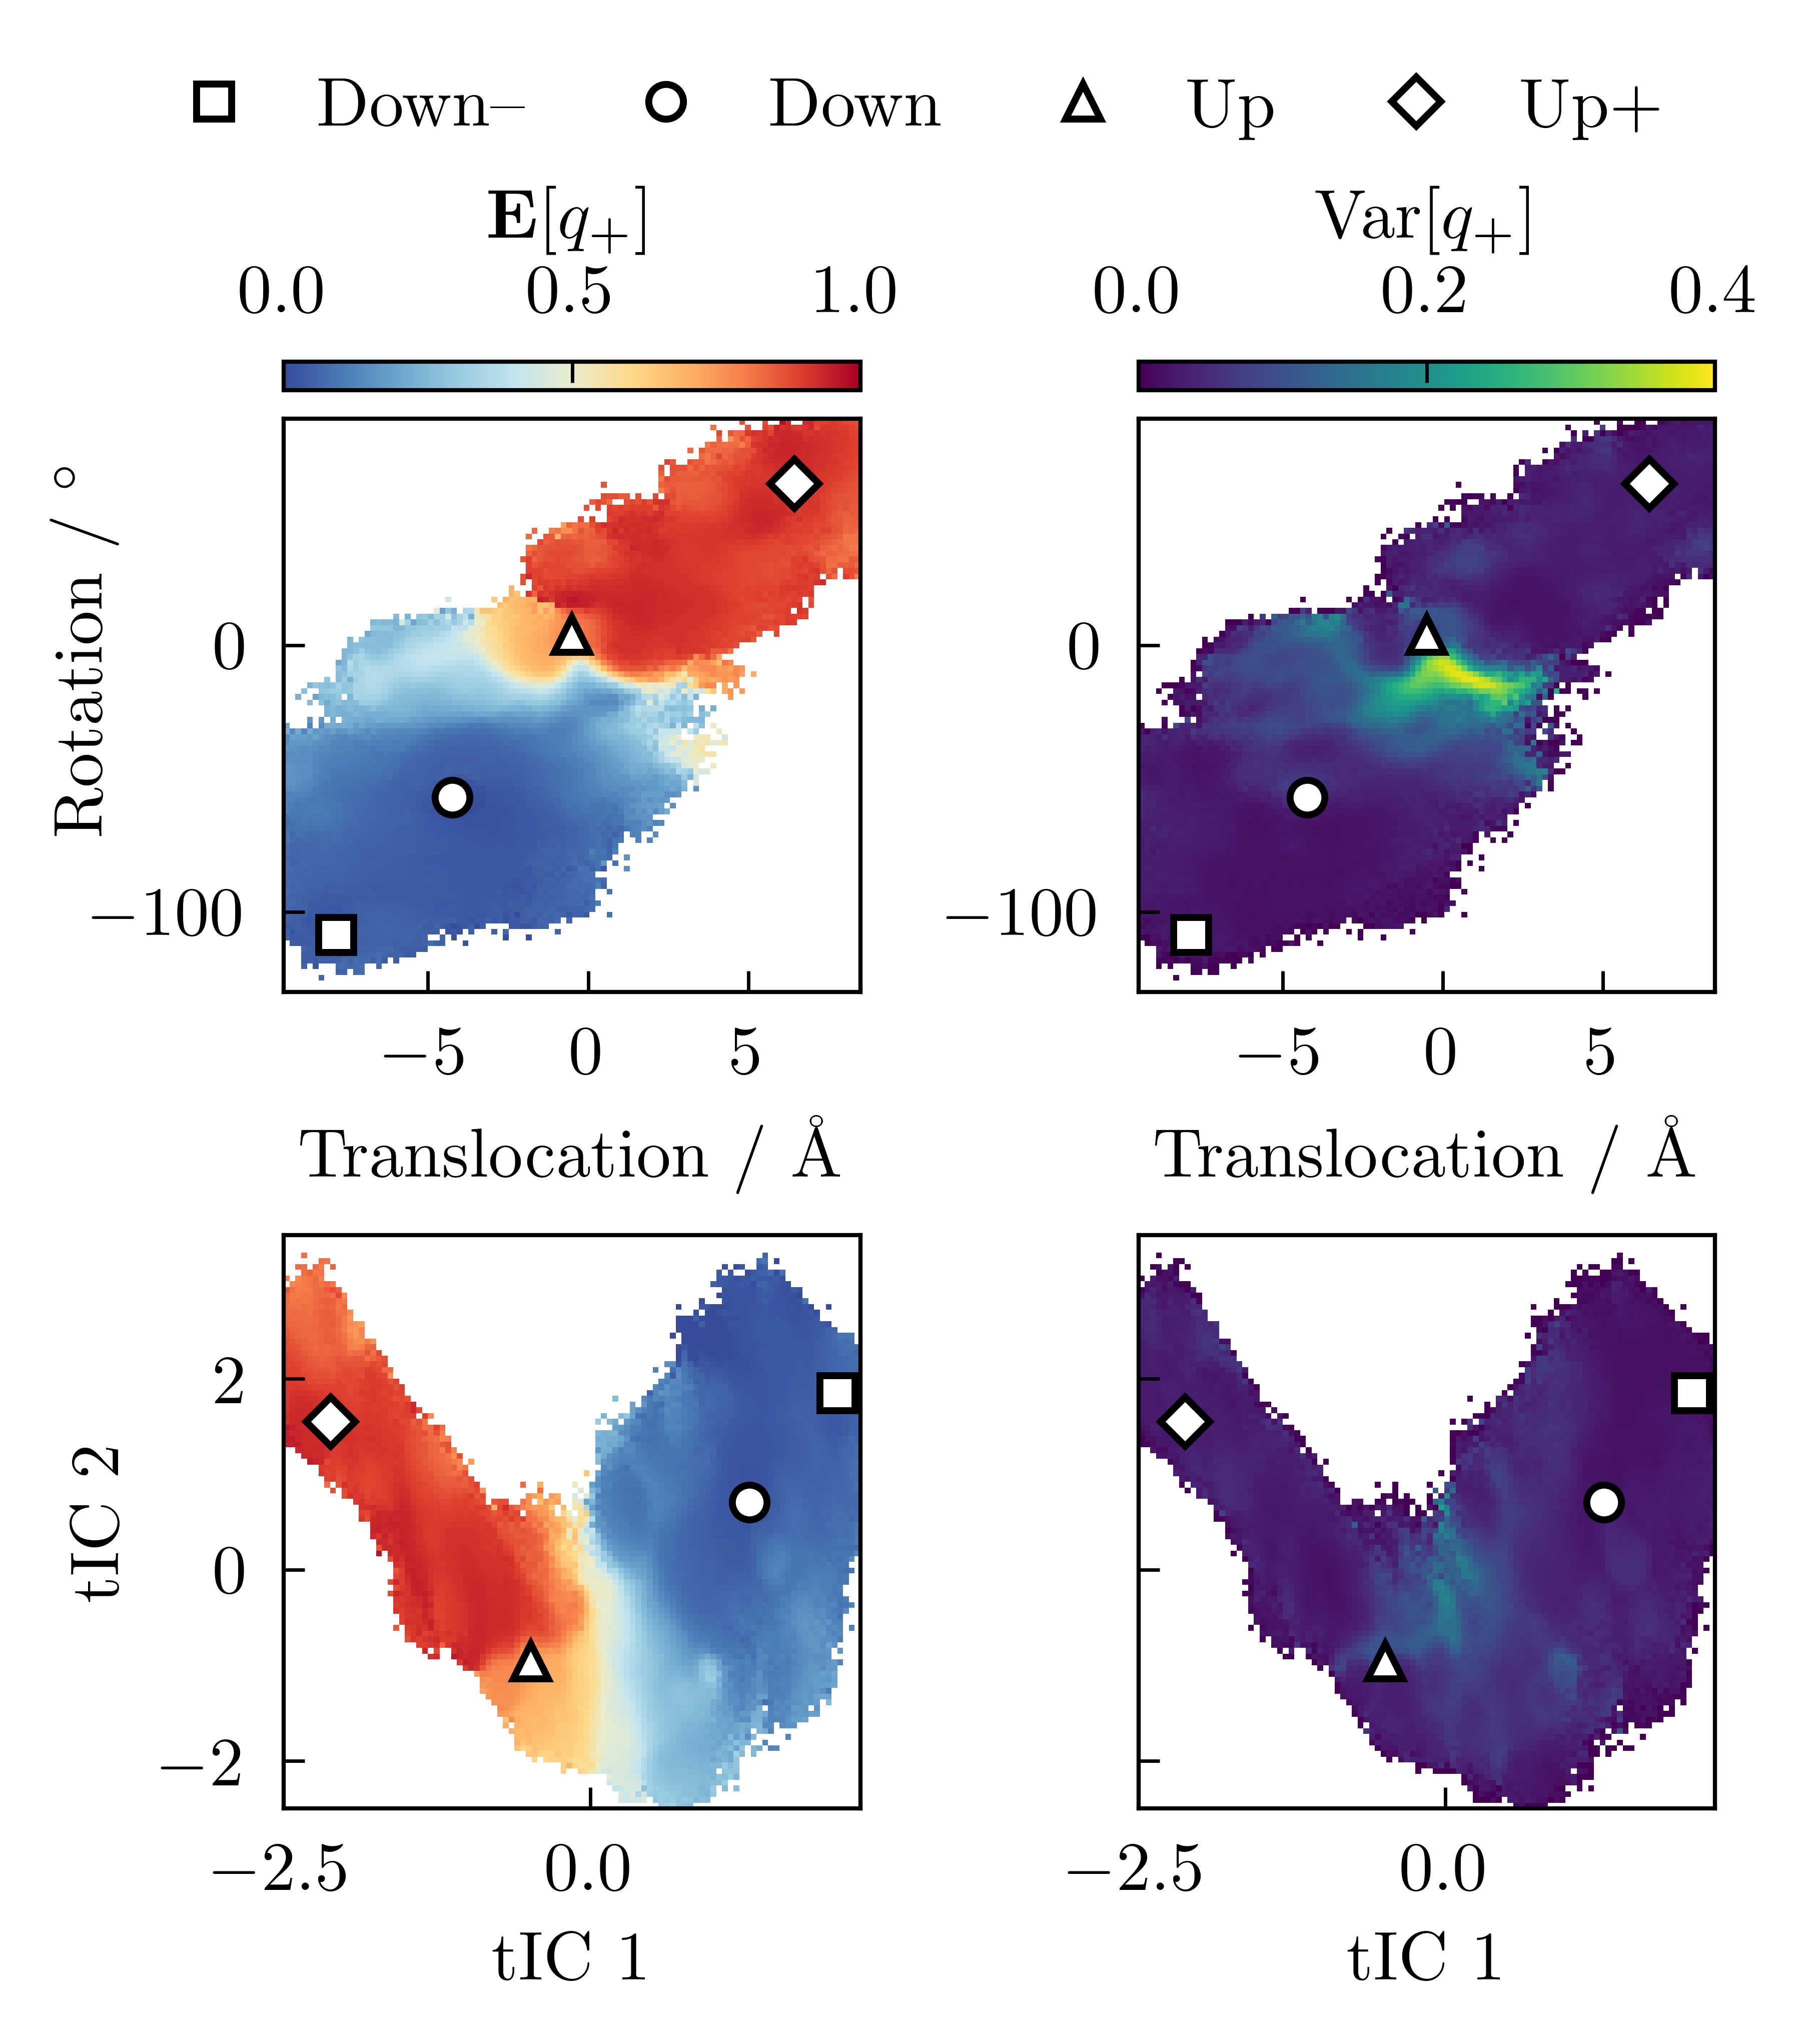

In [10]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(
    2, 2, figsize=(3.5, 3.7), dpi=500, constrained_layout=True
)

# S4 helix
xmin, xmax, ymin, ymax = -9.5, 8.5, -130, 85
xe = np.linspace(xmin, xmax, 101)
ye = np.linspace(ymin, ymax, 101)
q_avg = extq.projection.average2d(dist, rot, qp_du, weights, xe, ye)
qp_sq = [q ** 2 for q in qp_du]
q_avg_sq = extq.projection.average2d(dist, rot, qp_sq, weights, xe, ye)
q_std = np.sqrt(q_avg_sq - q_avg ** 2)

plotting.plot_models(ax0, models, ms=5, zorder=5)
plotting.plot_models(ax1, models, ms=5, zorder=5)
pc0 = ax0.pcolormesh(xe, ye, q_avg.T, cmap="diverging", vmin=0, vmax=1)
pc1 = ax1.pcolormesh(xe, ye, q_std.T, vmax=0.4)

for ax in (ax0, ax1):
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.set_xlabel("Translocation / Å")
ax0.set_ylabel("Rotation / $^\circ$", labelpad=-4.0, y=0.6)
    
xlim = np.linspace(-2.5, 2.2, 101)
ylim = np.linspace(-2.5, 3.5, 101)
q_avg_tic = extq.projection.average2d(tic1, tic2, qp_du, weights, xlim, ylim)
q_avg_sq_tic = extq.projection.average2d(tic1, tic2, qp_sq, weights, xlim, ylim)
q_std_tic = np.sqrt(q_avg_sq_tic - q_avg_tic ** 2)

plotting.plot_models(ax2, ivac_models[:, 1:3], ms=5, zorder=5)
plotting.plot_models(ax3, ivac_models[:, 1:3], ms=5, zorder=5)

pc0 = ax2.pcolormesh(xlim, ylim, q_avg_tic.T, cmap="diverging", vmin=0, vmax=1)
pc1 = ax3.pcolormesh(xlim, ylim, q_std_tic.T, vmax=0.4)

for ax in (ax2, ax3):
    ax.set_xlabel("tIC 1")
    ax.set_ylabel("tIC 2")
    ax.label_outer()
    
# colorbars
cb0 = plt.colorbar(pc0, ax=ax0, location='top')
cb0.set_label("$\mathbf{E}[q_+]$")
cb1 = plt.colorbar(pc1, ax=ax1, location='top')
cb1.set_label("$\mathrm{Var}[q_+]$")

# legend
fig.legend(
    bbox_to_anchor=(0.5, 1.03),
    loc="center",
    ncol=4,
    labels=["Down–", "Down", "Up", "Up+"],
    columnspacing=1,
    handletextpad=0.5
)
plt.savefig("../../fig/paper/qvariance_supp.pdf", bbox_inches='tight')